## 데이터 로드

In [16]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils.periodic_event_graph_utils import *
from utils.event_graph_utils import *
from utils.simple_periodic_event_graph_utils import *

warnings.filterwarnings('ignore')
random.seed(1127)

%matplotlib inline

In [2]:
# data load
def set_index_df(file_path, sheet_name):
    df = pd.read_excel(file_path, sheet_name = sheet_name, engine = 'openpyxl')
    df = df.drop(['Unnamed: 0', 'Total Consumption'], axis=1)
    df.set_index('Periods', inplace=True)
    df.index = pd.date_range(start='2023-01-01', periods=len(df), freq='15T')
    
    return df

new_directory = "/Users/soyoung/workspace/event_graph/data"
os.chdir(new_directory)

# Power consumption dataset
file_path = 'Dataset.xlsx'; sheet_name = 'PublicBuilding'
power = set_index_df(file_path, sheet_name)

power = power.drop(['AC4', 'Refrigerator'], axis=1)

In [ ]:
# data load
traffic = pd.read_csv("/Users/soyoung/workspace/event_graph/data/traffic.csv")
traffic.set_index('date', inplace=True)

# data shape change
df = traffic.iloc[:, 600:620]
print(df.shape)

In [ ]:
# data load
new_directory = "/Users/soyoung/workspace/event_graph/data"
os.chdir(new_directory)
exchange = pd.read_csv("exchange_rate.csv")
exchange.set_index('date', inplace=True)

## 제안 Event Garph 생성

In [4]:
# data shape
power.shape

(35136, 8)

In [5]:
# data shape change
df = power
print(df.shape)

(35136, 8)


In [6]:
# hyper-parameter
period = 4; window_stride = period
motifs_k = 5; min_cluster_size = 2

In [7]:
# STL
seasonal_data = apply_stl_seasonal(df, period)
residual_data = apply_stl_residual(df, period)

In [8]:
# period dict
seasonal_dict = dominant_periods(seasonal_data)

In [9]:
print(seasonal_dict.values())
print('평균', int(np.mean(list(seasonal_dict.values()))))
size = period * int(np.mean(list(seasonal_dict.values())))
print(size)

dict_values([4, 4, 4, 4, 4, 4, 3, 4])
평균 3
12


In [10]:
# seasonal matrix profile # matrix_profile_set(data_dict, dict, top_k, periods)
seasonal_mp_set = matrix_profile_set(seasonal_data, seasonal_dict, motifs_k, period)

In [11]:
# seasonal event generation # event_generation_set(data_dict, mp_set, dict, periods, cluster_size = 2)
seasonal_event_set = event_generation_set(seasonal_data, seasonal_mp_set, seasonal_dict, period, min_cluster_size)
print(len(seasonal_event_set))

6


In [12]:
# residual matrix profile
residual_mp_set = matrix_profile_set(residual_data, seasonal_dict, motifs_k, period)

In [13]:
# residual event generation
residual_event_set = event_generation_set(residual_data, residual_mp_set, seasonal_dict, period, min_cluster_size)
print(len(residual_event_set))

5


In [14]:
# seasonal window
seasonal_window = extract_windows_df(df, seasonal_data, seasonal_dict, period, window_stride, size)
print(len(seasonal_window))

8782


In [15]:
# residual window
residual_window = extract_windows_df(df, residual_data, seasonal_dict, period, window_stride, size)
print(len(residual_window))

8782


In [28]:
# pattern node
pattern_node = pattern_matching_df(seasonal_window, seasonal_event_set)

In [29]:
# residual node
residual_node = pattern_matching_df(residual_window, residual_event_set)

In [30]:
seasonal_map = list(seasonal_event_set.keys())
residual_map = list(residual_event_set.keys())
seasonal_mapping = {event: idx for idx, event in enumerate(seasonal_map)}
residual_mapping = {event: idx for idx, event in enumerate(residual_map)}

In [31]:
pattern_mapped = pattern_node.copy() 
for column in pattern_node.columns:
    pattern_mapped[column] = pattern_node[column].map(seasonal_mapping)

residual_mapped = residual_node.copy() 
for column in residual_node.columns:
    residual_mapped[column] = residual_node[column].map(residual_mapping)

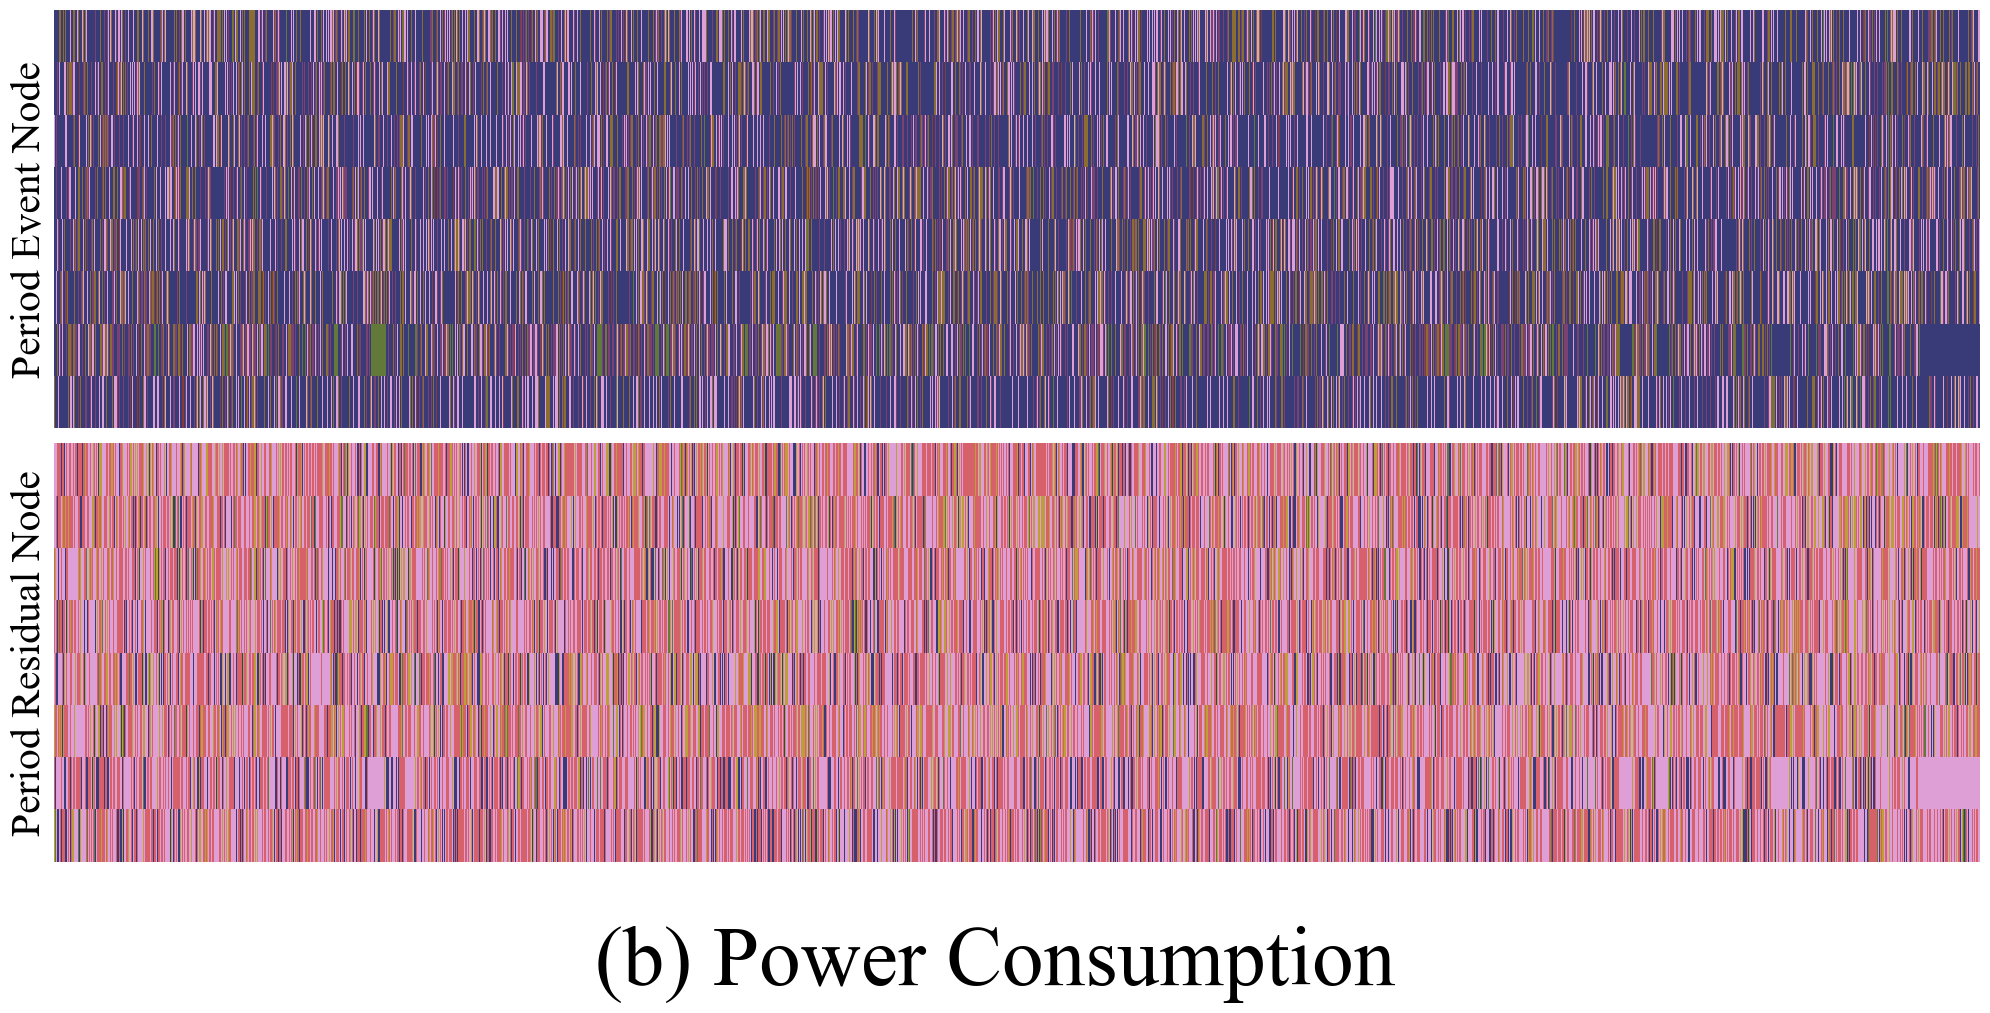

<Figure size 1920x1440 with 0 Axes>

In [33]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1) 
sns.heatmap(pattern_mapped.T, cmap='tab20b', cbar=False, xticklabels=False, yticklabels=False)
plt.ylabel('Period Event Node', fontsize=30)

plt.subplot(2, 1, 2) 
sns.heatmap(residual_mapped.T, cmap='tab20b_r', cbar=False, xticklabels=False, yticklabels=False)
plt.ylabel('Period Residual Node', fontsize=30)

plt.text(0.5, 0.01, '(b) Power Consumption', ha='center', fontsize=60, transform=plt.gcf().transFigure)
plt.tight_layout()
plt.figure(dpi=300)
plt.show()

In [23]:
# graph generation
graph = event2graph_df(pattern_node, residual_node, seasonal_event_set, residual_event_set)

In [24]:
ls = list(graph['i'].unique()); ls.sort(); print(ls)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [25]:
# pattern graph extraction
pattern_graph = graph[::2]

In [26]:
ls = list(pattern_graph['i'].unique()); ls.sort(); print(ls)

[0, 1, 2, 3, 4, 5]


## 하이브리드 Event Graph 생성

In [28]:
# residual window v2
residual_window_v2 = extract_residual_windows_df(seasonal_window, seasonal_event_set, pattern_node)

In [29]:
# threshold window #extract_threshold_windows_df(df, size, stride, init_level = 0.8):
threshold_window = extract_threshold_windows_df(df, seasonal_data, size, window_stride)

In [30]:
# residual node v2
residual_node_v2 = residual_matching_df(residual_window_v2, threshold_window)

In [31]:
# graph generation
hb_graph = event2graph_df(pattern_node, residual_node_v2, seasonal_event_set)

In [33]:
l1 = list(hb_graph['i'].unique()); l1.sort(); print(l1)

[0, 1, 2, 3, 4, 5, 6]


## Graph save

In [35]:
# save the graph
new_directory = "/Users/soyoung/workspace/event_graph/library/DyGLib"; os.chdir(new_directory)

graph.to_csv('./DG_data/power_new_pr/power_new_pr.csv', sep = ',', index = False)
pattern_graph.to_csv('./DG_data/power_new_p/power_new_p.csv', sep = ',', index = False)
hb_graph.to_csv('./DG_data/power_new_hb/power_new_hb.csv', sep = ',', index = False)

## Preprocessing

In [36]:
!python preprocess_data/preprocess_data.py --dataset_name power_new_pr
!python preprocess_data/preprocess_data.py --dataset_name power_new_p
!python preprocess_data/preprocess_data.py --dataset_name power_new_hb

preprocess dataset power_new_pr...
number of nodes  18
number of node features  172
number of edges  140512
number of edge features  18
power_new_pr is processed successfully.
preprocess dataset power_new_p...
number of nodes  14
number of node features  172
number of edges  70256
number of edge features  18
power_new_p is processed successfully.
preprocess dataset power_new_hb...
number of nodes  15
number of node features  172
number of edges  140512
number of edge features  15
power_new_hb is processed successfully.
